# Algorithms of cluster analysis for radionuclide identification
## Table of Contents
- Introduction 
- The problem statement
- Import libraries 
- Import dataset
- Info about computer
- Defend functions and init parametrs
- Subtractive Clustering (SC)
- Fuzzy C-Means Method (FCM)
- Optimization (SC + FCM)

### Introduction
After the location of the source of ionizing radiation is established, it is necessary to determine a certain type of radionuclide, which is associated with safety considerations, as well as with the scale of response actions after the detection of radioactive material. To achieve this goal, the application of a subtractive clustering algorithm and fuzzy c-means algorithm is proposed.
### The problem statement
Naturally Occurring Radioactive Materials (NORM)) is a term used to refer to all naturally occurring radioactive materials that occur naturally or where human activity has increased the exposure potential compared to an unchanged situation. These materials potentially include all radioactive elements found in the environment, such as uranium, thorium and potassium. Any products of their decay also pose a serious threat. Moreover, at the current rate of use of nuclear reactions, namely for the production of electricity, the possibility of nuclear accidents cannot be neglected, therefore control and monitoring should be strengthened and improved. It is important not only to detect, but also to identify detected radioactive sources. Identification of an unknown source is usually important, since this information can indicate the cause of such radiation detection, as well as determine how to reduce the risks associated with it.
Classical gamma spectroscopy includes many stages, a longer analysis and, as a rule, the involvement of an expert to achieve the identification result. The identification of a specific type of radionuclide may be important for safety reasons, for taking protective measures after the detection of radioactive material. Each radionuclide is characterized by a half-life and specific, inherent only to it, spectra (energies) of ionizing radiation. It is precisely the energy of gamma radiation that makes it possible to identify the gamma-emitting radionuclide present in the material that is the source of ionizing radiation.

### Import libraries 

In [1510]:
from src.sc import SubtractiveClustering
from src.fcm import FuzzyCMeans
import pandas
import numpy
import numpy.typing as npt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [8, 5]

import warnings
warnings.filterwarnings('ignore')
# numpy.random.seed(0) # makes the random numbers predictable



### Import dataset

In [1511]:
radionuclides = ['Cs-137', 'K-40', 'Th-228', 'Ra-226', 'Am-241', 'Co-60']
# Multicomponent sample #1 (Cs-137 + Ra-226 + Th-228 + K-40)
MS1 = pandas.read_csv('test/MS1.csv')
# Multicomponent sample #2 (Cs-137 + K-40)
MS2 = pandas.read_csv('test/MS2.csv')
# Multicomponent sample #3 (Am-241 + Co-60 + Cs-147)
MS3 = pandas.read_csv('test/MS3.csv')

### Info about computer

In [1512]:
import cpuinfo
my_cpuinfo = cpuinfo.get_cpu_info()
print(f"Full CPU Name: {my_cpuinfo['brand_raw']}")
print(f"CPU architecture: {my_cpuinfo['arch']}")
import psutil
print(f"Total RAM: {psutil.virtual_memory().total / 1024 / 1024 / 1024:.2f} GB")

Full CPU Name: Intel(R) Pentium(R) Gold G5400 CPU @ 3.70GHz
CPU architecture: X86_64
Total RAM: 15.87 GB


### Defend functions and init parametrs

In [1513]:
def plotting(data: npt.NDArray, centroids: npt.NDArray, title: str, plots: int, norma: bool, num_cntr: int, nc: str, y_scale: str) -> None:
    '''
     # Suplottings 
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
    '''
    fig, ax = plt.subplots(plots)
    ax.set_title(title, fontsize=11)
    ax.scatter([i[0] for i in data], [i[1] for i in data], c = 'black',s = 10, alpha = 0.1, label = 'Spectrum data')
    ax.scatter([i[0] for i in centroids], [i[1] for i in centroids], marker='X', color = 'black', s = 50, label = 'Centroids clusters ($n={}$)'.format(num_cntr))
    ax.legend(fontsize=9)
    ax.set_xlabel('Channel', fontsize=9)
    ax.set_ylabel('Counts', fontsize=9)
    ax.set_yscale(y_scale)
    if norma and nc == 'MS2':
        ax.text(0.18,0.65,'Cs-137', fontweight='bold', fontsize=9)
        ax.text(0.45,0.3,'K-40', fontweight='bold', fontsize=9)
        ax.text(0.8,0.08,'Th-228', fontweight='bold', fontsize=9)
    elif not norma and nc == "MS2":     
        ax.text(180,170,'Cs-137', fontweight='bold', fontsize=9)
        ax.text(450,80,'K-40', fontweight='bold', fontsize=9)
        ax.text(810,8,'Th-228', fontweight='bold', fontsize=9)
    elif norma and nc == 'MS1':
        ax.text(0.2,0.21,'Cs-137', fontweight='bold', fontsize=9)
        ax.text(0.45,0.1,'K-40', fontweight='bold', fontsize=9)
        ax.text(0.8,0.05,'Th-228', fontweight='bold', fontsize=9)
        ax.text(0.13,0.15,'Ra-226', fontweight='bold', fontsize=9)
        ax.text(0.08,0.67,'Ra-226', fontweight='bold', fontsize=9)
    elif not norma and nc == 'MS1':
        ax.text(200,1000,'Cs-137', fontweight='bold', fontsize=9)
        ax.text(460,330,'K-40', fontweight='bold', fontsize=9)
        ax.text(835,40,'Th-228', fontweight='bold', fontsize=9)
        ax.text(110,550,'Ra-226', fontweight='bold', fontsize=9, bbox={'facecolor': 'grey', 'alpha': 0.7, 'pad': 5})
        ax.text(50,3000,'Ra-226', fontweight='bold', fontsize=9)   
    elif norma and nc == 'MS3':
        ax.text(0.18,0.21,'Cs-137', fontweight='bold', fontsize=9)
        ax.text(0.37,0.1,'Co-60', fontweight='bold', fontsize=9)
        ax.text(0.03,1,'Am-241', fontweight='bold', fontsize=9)
    elif not norma and nc == 'MS3':
        ax.text(180,20000,'Cs-137', fontweight='bold', fontsize=9)
        ax.text(380,4000,'Co-60', fontweight='bold', fontsize=9)
        ax.text(40,50000,'Am-241', fontweight='bold', fontsize=9)
    plt.show()

# Parametrs for SC
global r1
global r2
r1 = 12; r2 = r1 * 1.15   

### Subtractive Clustering

In [1514]:
# Case normalise into unit hyperbox with constant parametrs
algorithm = 'SC'

In [1515]:
# MS1
n_case = 'MS1'
norma_data = MS1.copy()
for i in range(0,MS1.shape[1]):
        norma_data.iloc[:, i] = (norma_data.iloc[:,i] - norma_data.min(axis = 0)[i])  / (norma_data.max(axis = 0)[i] - norma_data.min(axis = 0)[i])
norma_data = norma_data.to_numpy()
sc = SubtractiveClustering(r1,r2,verbose=False).fit(norma_data)
cntr = sc.centers

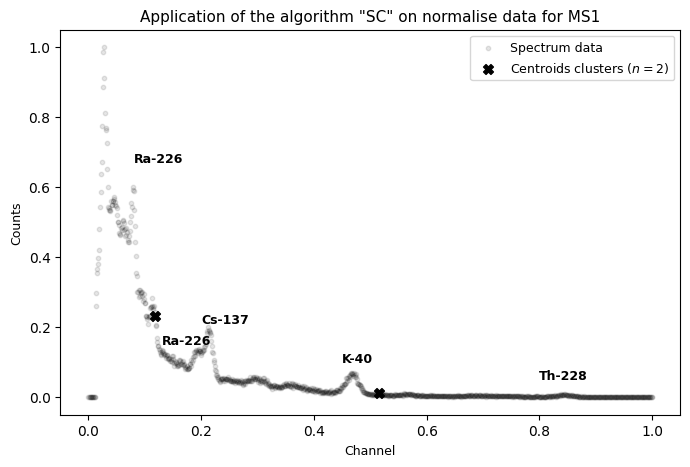

In [1516]:
plotting(norma_data, cntr, title = 'Application of the algorithm "{}" on normalise data for {}'.format(algorithm, n_case), 
         plots = 1, norma = True, num_cntr = len(cntr), nc = n_case, y_scale = 'linear')

In [1517]:
# MS2
n_case = 'MS2'
norma_data = MS2.copy()
for i in range(0,MS2.shape[1]):
        norma_data.iloc[:, i] = (norma_data.iloc[:,i] - norma_data.min(axis = 0)[i])  / (norma_data.max(axis = 0)[i] - norma_data.min(axis = 0)[i])
norma_data = norma_data.to_numpy()
sc = SubtractiveClustering(r1,r2,verbose=False).fit(norma_data)
cntr = sc.centers

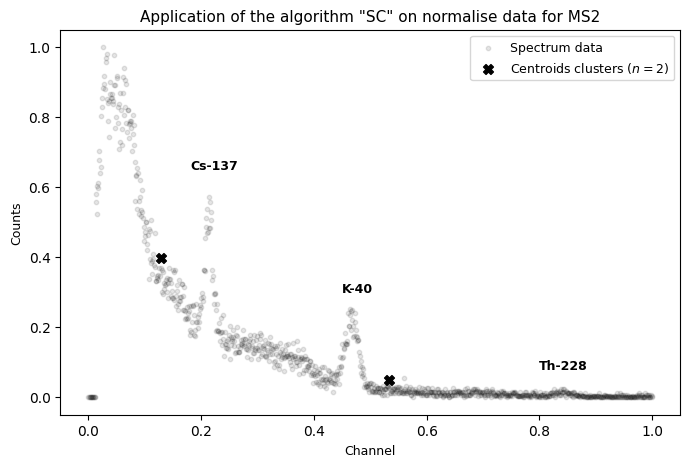

In [1518]:
# Plotting
plotting(norma_data, cntr, title = 'Application of the algorithm "{}" on normalise data for {}'.format(algorithm, n_case), 
         plots = 1, norma = True, num_cntr = len(cntr), nc = n_case, y_scale = 'linear')

In [1519]:
# MS3
n_case = 'MS3'
norma_data = MS3.copy()
for i in range(0,MS3.shape[1]):
        norma_data.iloc[:, i] = (norma_data.iloc[:,i] - norma_data.min(axis = 0)[i])  / (norma_data.max(axis = 0)[i] - norma_data.min(axis = 0)[i])
norma_data = norma_data.to_numpy()
sc = SubtractiveClustering(r1,r2,verbose=False).fit(norma_data)
cntr = sc.centers

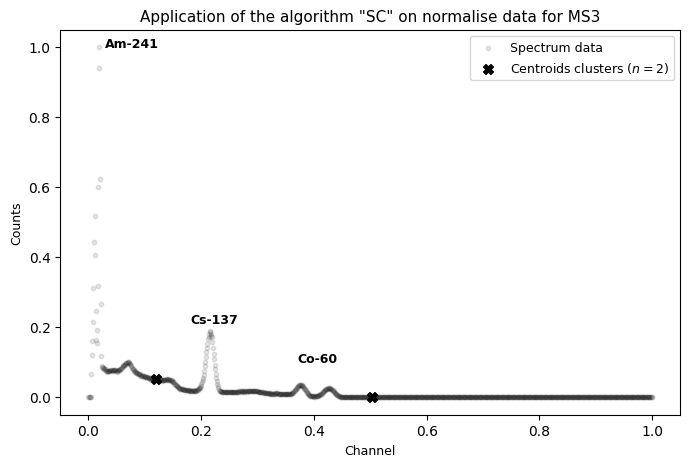

In [1520]:
plotting(norma_data, cntr, title = 'Application of the algorithm "{}" on normalise data for {}'.format(algorithm, n_case), 
         plots = 1, norma = True, num_cntr = len(cntr), nc = n_case, y_scale = 'linear')

In [1521]:
# Case without normalization
n_case = 'MS1'
sc = SubtractiveClustering(r1,r2).fit(MS1.to_numpy())
cntr = sc.centers

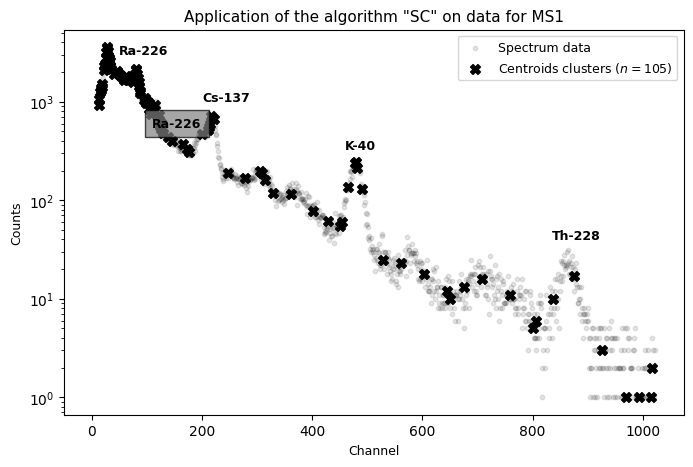

In [1522]:
plotting(MS1.to_numpy(), cntr, title = 'Application of the algorithm "{}" on data for {}'.format(algorithm, n_case), 
         plots = 1, norma = False,  num_cntr = len(cntr), nc = n_case, y_scale = 'log')

In [1523]:
n_case = 'MS2'
sc = SubtractiveClustering(r1,r2).fit(MS2.to_numpy())
cntr = sc.centers

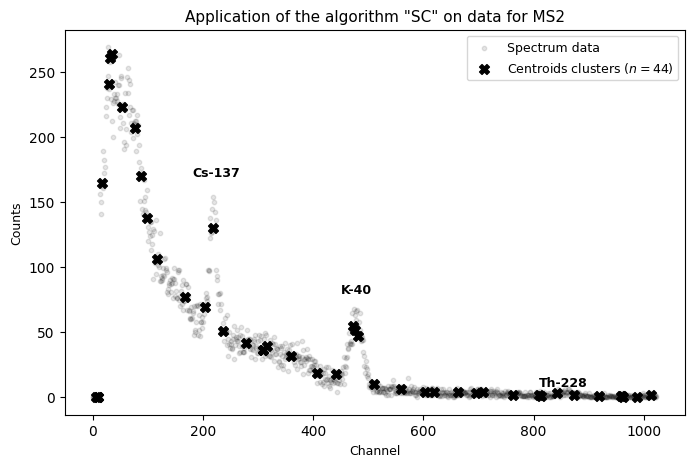

In [1524]:
plotting(MS2.to_numpy(), cntr, title = 'Application of the algorithm "{}" on data for {}'.format(algorithm, n_case), 
         plots = 1, norma = False,  num_cntr = len(cntr), nc = n_case, y_scale = 'linear')

In [1525]:
n_case = 'MS3'
# r1 = 40; r2 = r1 * 1.15
sc = SubtractiveClustering(r1,r2).fit(MS3.to_numpy())
cntr = sc.centers

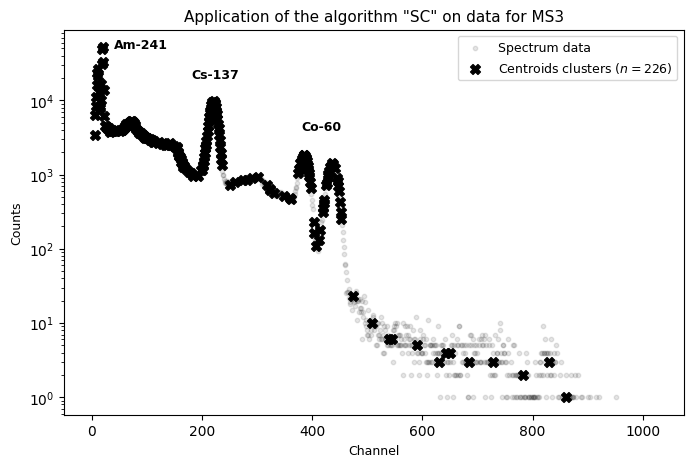

In [1526]:
plotting(MS3.to_numpy(), cntr, title = 'Application of the algorithm "{}" on data for {}'.format(algorithm, n_case), 
         plots = 1, norma = False,  num_cntr = len(cntr), nc = n_case, y_scale = 'log')

### Fuzzy C-Means Method


In [ ]:
algorithm = 'FCM'
model = FuzzyCMeans(3, verbose=False, tol_iter=100)
model.fit(MS2.to_numpy())
cntr = model.cluster_centers_

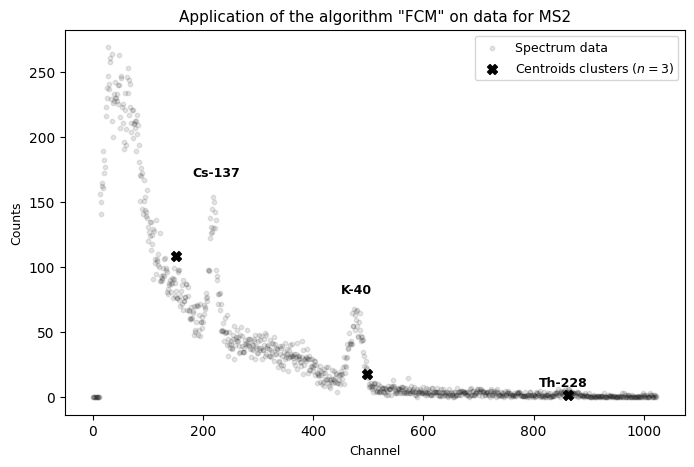

In [ ]:
plotting(MS2.to_numpy(), cntr, title = 'Application of the algorithm "{}" on data for {}'.format(algorithm, n_case), plots = 1, norma = False,  num_cntr = len(cntr))

In [ ]:
model = FuzzyCMeans(3, verbose=False)
model.fit(norma_data)
cntr = model.cluster_centers_

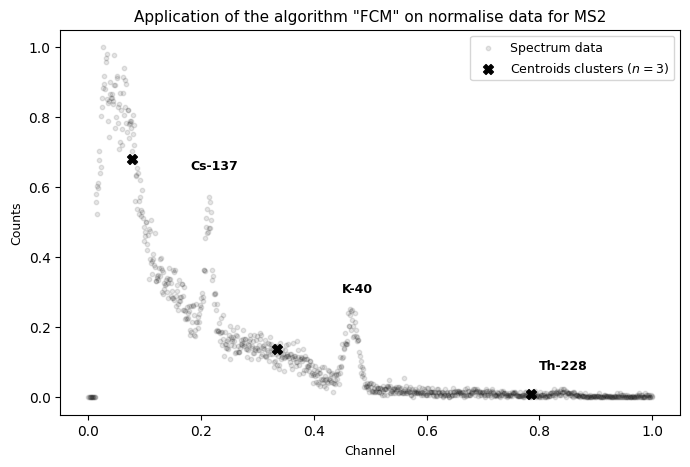

In [ ]:
plotting(norma_data, cntr, title = 'Application of the algorithm "{}" on normalise data for {}'.format(algorithm, n_case), plots = 1, norma = True,  num_cntr = len(cntr))

### SC+FCM (optimization)


In [ ]:
# Normalization case
algorithm = 'SC + FCM'
sc = SubtractiveClustering(r1,r2).fit(norma_data)
cntr = sc.centers
l_cntr = len(cntr)
model = FuzzyCMeans(l_cntr, verbose=False)
model.fit(norma_data)
cntr = model.cluster_centers_

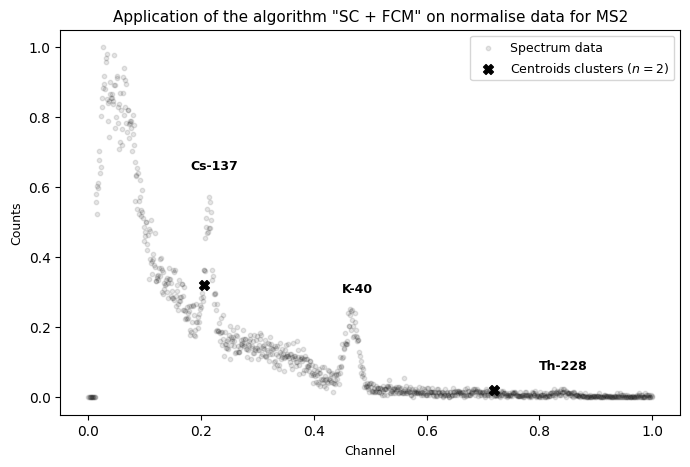

In [ ]:
plotting(norma_data, cntr, title = 'Application of the algorithm "{}" on normalise data for {}'.format(algorithm, n_case), plots = 1, norma = True,  num_cntr = len(cntr))

In [ ]:
sc = SubtractiveClustering(r1,r2).fit(MS2.to_numpy())
cntr = sc.centers
l_cntr = len(cntr)
model = FuzzyCMeans(l_cntr, verbose=False)
model.fit(MS2.to_numpy())
cntr = model.cluster_centers_
print(r1)

12


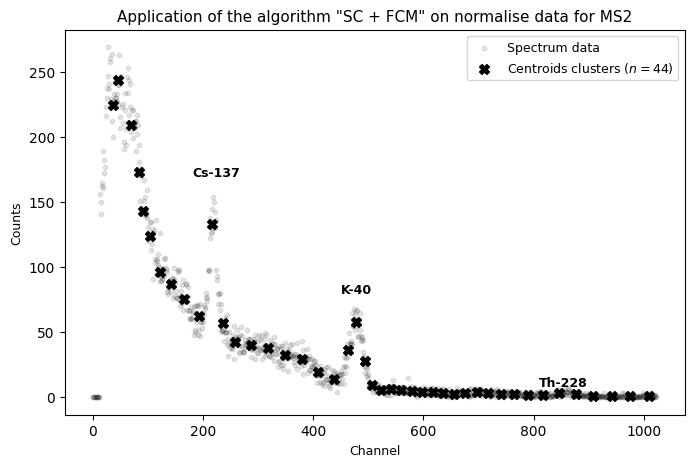

In [ ]:
plotting(MS2.to_numpy(), cntr, title = 'Application of the algorithm "{}" on normalise data for {}'.format(algorithm, n_case), plots = 1, norma = False,  num_cntr = len(cntr))